# CMPINF 0010 Final Project
---
In this final project, our team has been tasked to find the best neighborhood in Pittsburgh through our own metrics.

## Metric 1 - Arrest/Crime Data
---
One of the first metrics that our group thought of was safety, no matter what the benefits of a neighborhood are, if there is a high crime rate

<AxesSubplot:>

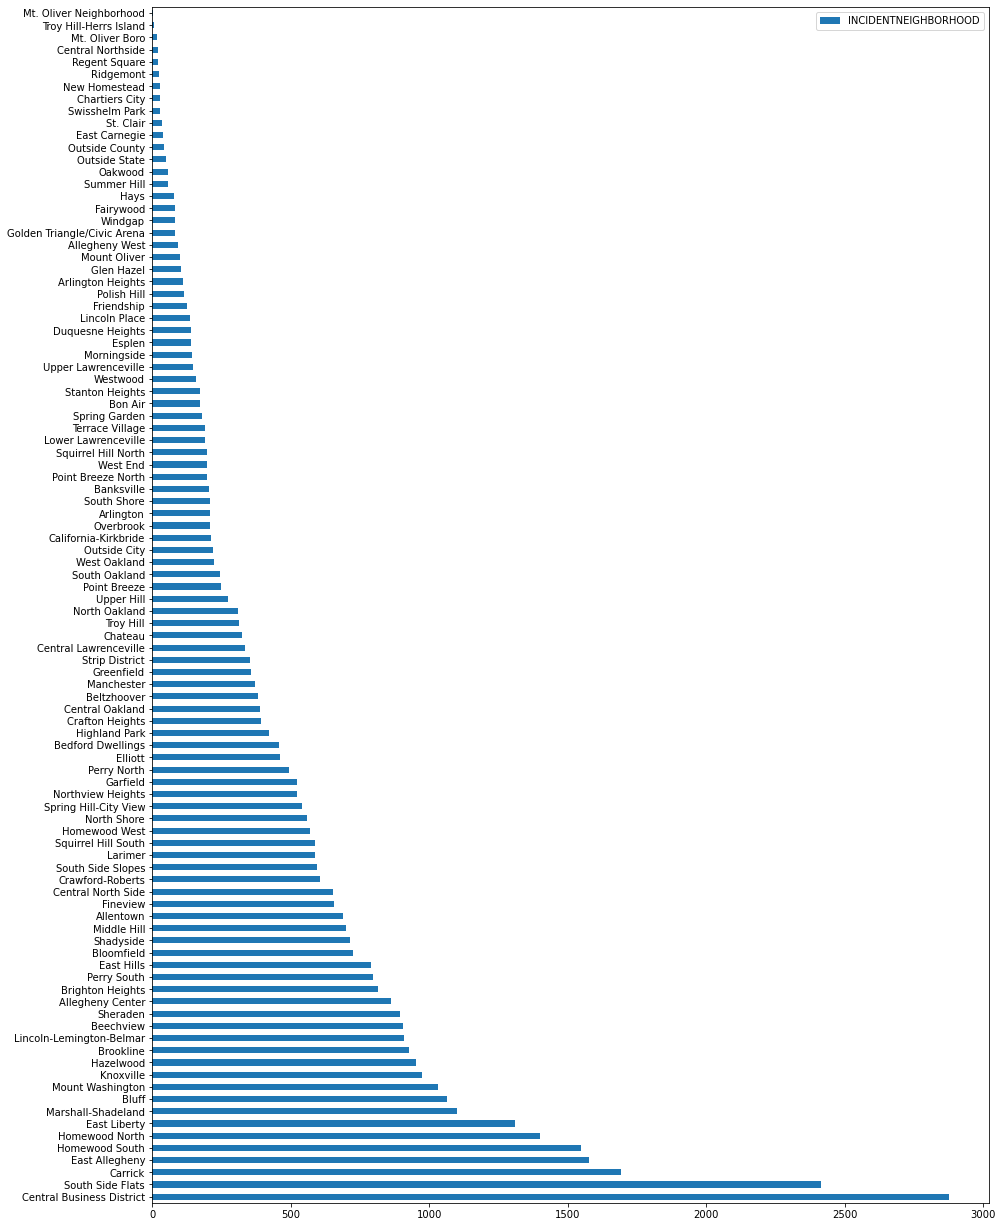

In [1]:
import pandas as pd
import geopandas
%matplotlib inline

arrests = pd.read_csv("Arrests.csv")

locations = pd.DataFrame(arrests["INCIDENTNEIGHBORHOOD"].value_counts())
#may want to sort by descending

locations.plot.barh(figsize = (15, 22))

<AxesSubplot:>

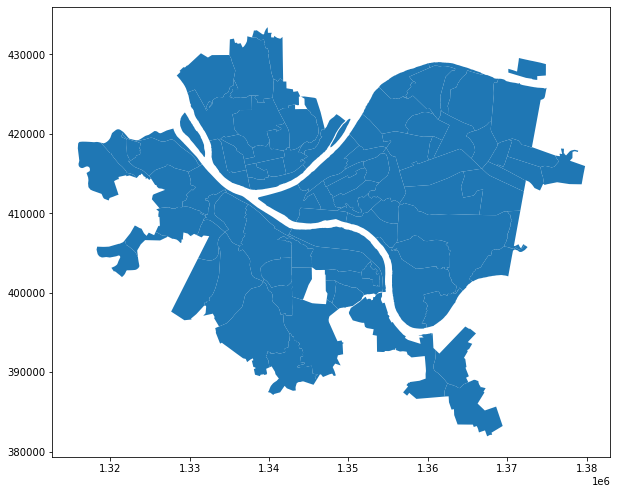

In [2]:
#YOU CAN ALL USE THE NEIGHBORHOODS MAP AS A BASE IF YOU WANT TO PLOT
neighborhoods = geopandas.read_file("Neighborhoods/Neighborhoods_.shp")
neighborhoods.plot(figsize = (10,10))

In [3]:
neighborhoods[['hood','area','perimeter','geometry']]

,hood,area,perimeter,geometry
0,Chateau,10688264.0,80995.806272,"POLYGON ((1334127.196 418284.606, 1334150.461 ..."
1,Summer Hill,12232021.0,80995.806272,"POLYGON ((1339850.631 432956.640, 1339858.400 ..."
2,Northview Heights,8739570.0,80995.806272,"POLYGON ((1341778.327 426695.719, 1341780.150 ..."
3,Spring Hill-City View,17550592.0,80995.806272,"POLYGON ((1343276.368 423702.914, 1343276.483 ..."
4,Perry South,25220622.0,80995.806272,"POLYGON ((1338684.967 424859.918, 1338646.933 ..."
...,...,...,...,...
85,Overbrook,23393388.0,198927.416142,"POLYGON ((1342891.744 394551.341, 1342898.949 ..."
86,Chartiers City,3683600.5,198927.416142,"POLYGON ((1323234.375 419070.000, 1323255.578 ..."
87,Esplen,6409852.5,198927.416142,"POLYGON ((1328174.017 420097.302, 1328211.790 ..."
88,Ridgemont,10278895.0,198927.416142,"POLYGON ((1332686.375 409054.375, 1332703.750 ..."


## Metric 2 - Older Housing Data 
---
Another metric that our group thought of was how old are the houses between the neighborhoods. Older housing is found to be unpleasant and also dangerous. 

Older houses with household lead paint and contaminated lead waters cause more exposure to lead which is a neurotoxin that can result in serious health problems, especially for pregnant women and children. It has been shown to affect IQ, ability to pay attention, academic achievement, and other behavioral issues.


In [8]:
#tract is the number of the tract 
#pre1950 represents the percent of homes in each census tract that were built on or before 1950
older_house_data = pd.read_csv("pre1950housing.csv")
older_house_data.head()

,TRACT,Pre1950
0,10300,0.658477
1,20100,0.321088
2,20300,0.724907
3,30500,0.324117
4,40200,0.463549


In [9]:
#neighborhoods corresponding the tract numbers
older_house_data = pd.read_csv("Pittsburgh_Census_Tracts_2010.csv")
older_house_data.head()

,Neighborhood,Census Tracts
0,Allegheny Center,562700
1,Allegheny West,562700
2,Allentown,180300
3,Arlington,561600
4,Arlington Heights,561600


In [10]:
#the data on percent venous confirmed elevated blood lead levels (EBLLs)(≥5 μg/dL)
#for Allegheny County children less than 6 years of ageby assigned geography for 2015-2019
lead_data = pd.read_csv("Blood_Lead_Level_Rates.csv")
lead_data.head()

,SchoolDistrict,percentEBLL2015,note2015,percentEBLL2016,note2016,percentEBLL2017,note2017,percentEBLL2018,note2018,percentEBLL2019,note2019,percentEBLL15_19,note15_19
0,Allegheny Valley,0.00,"Unstable percent, interpret with caution",0.00,"Unstable percent, interpret with caution",0.92,"Unstable percent, interpret with caution",0.68,"Unstable percent, interpret with caution",0.00,"Unstable percent, interpret with caution",0.43,"Unstable percent, interpret with caution"
1,Avonworth,0.72,"Unstable percent, interpret with caution",0.75,"Unstable percent, interpret with caution",0.55,"Unstable percent, interpret with caution",0.89,"Unstable percent, interpret with caution",2.00,"Unstable percent, interpret with caution",1.15,NaN
2,Baldwin-Whitehall,0.91,"Unstable percent, interpret with caution",0.59,"Unstable percent, interpret with caution",1.40,NaN,1.42,NaN,0.49,"Unstable percent, interpret with caution",1.05,NaN
3,Bethel Park,0.00,"Unstable percent, interpret with caution",0.00,"Unstable percent, interpret with caution",0.61,"Unstable percent, interpret with caution",0.18,"Unstable percent, interpret with caution",0.89,"Unstable percent, interpret with caution",0.51,"Unstable percent, interpret with caution"
4,Brentwood Borough,1.60,"Unstable percent, interpret with caution",1.35,"Unstable percent, interpret with caution",3.45,"Unstable percent, interpret with caution",2.68,"Unstable percent, interpret with caution",2.54,"Unstable percent, interpret with caution",2.46,NaN


## Metric 3 - 
---

## Conclusion
---